In [1]:
import os
import yaml
import pandas as pd
import subprocess
from BigDFT import Logfiles as lf
import math
import numpy as np
import plotting_wrappers

In [2]:
Ha2eV = 27.211386245988

In [3]:
def yaml_loader(file_path):
    """Loads a yaml file"""
    with open(file_path, "r") as file_descriptor:
        data = yaml.load(file_descriptor)
    return data


In [4]:
# molecules = ['naphthalene', 'anthracene', 'tetracene', 'pentacene', 'CBP', 'PhCz', '2CzPN', 'PXZ-OXD']
molecules = ['2CzPN', 'CBP']
xcs = ['PBE']
codes = ['BigDFT', 'NWChem']
basis = ['cubic', 'VDZ', 'VTZ', 'VQZ']
HL_order = ['HOMO-1', 'HOMO', 'LUMO', 'LUMO+1']

In [5]:
data = {}

for molecule in molecules:
    data[molecule] = {}
    
    for code in codes:
        data[molecule][code] = {}
        
        for xc in xcs:
            
            for bas in basis:
            
                nw_file = molecule+'_'+xc+'_s0xyz_s0_VTZ.out'

                if code == 'NWChem' and (xc == 'LDA' or xc == 'PBE' or xc == 'B3LYP') and bas == 'VTZ':
                    data[molecule][code][xc] = {}
                    data[molecule][code][xc][bas] = {}

                    #placeholder, for table later, for easier ordering
                    for HL in HL_order:
                        data[molecule][code][xc][bas][HL] = float('nan')
                    

                    if os.path.exists(nw_file):
    #                     print 'READING file', nw_file
                        file = open(nw_file).readlines()

                        occups = []

                        for line in file:
                            if 'Vector' in line:

                                occups.append(line)

                        for i in range(0,len(occups)):
                            occ = int(occups[i][18])
#                             eigval = float(occups[i][34:47].replace('D','E')) * Ha2eV

                            if occ == 0:

                                homo_m_1 = float(occups[i-2][34:47].replace('D','E')) * Ha2eV
                                homo = float(occups[i-1][34:47].replace('D','E')) * Ha2eV
                                lumo = float(occups[i][34:47].replace('D','E')) * Ha2eV
                                lumo_p_1 = float(occups[i+1][34:47].replace('D','E')) * Ha2eV

                                data[molecule][code][xc][bas]['HOMO-1'] = homo_m_1
                                data[molecule][code][xc][bas]['HOMO'] = homo
                                data[molecule][code][xc][bas]['LUMO'] = lumo
                                data[molecule][code][xc][bas]['LUMO+1'] = lumo_p_1

                                break
                    else:
                        print nw_file, 'file NOT FOUND.'

                elif code == 'BigDFT' and bas == 'cubic':
                    data[molecule][code][xc] = {}
                    data[molecule][code][xc][bas] = {}

                    #placeholder, for table later, for easier ordering
                    data[molecule][code][xc][bas]['HOMO-1'] = float('nan')
                    data[molecule][code][xc][bas]['HOMO'] = float('nan')
                    data[molecule][code][xc][bas]['LUMO'] = float('nan')
                    data[molecule][code][xc][bas]['LUMO+1'] = float('nan')

                    f_name = 'log-'+molecule+'_'+xc+'_s0xyz_s0_cubic.yaml'

                    if os.path.exists(f_name):

                        log = lf.Logfile(f_name)
                        orbital_energies = log.evals[0][0]

                        tot_electrons = log.log['Total Number of Electrons']
#                     tot_orbs = log.log['Total Number of Orbitals'] # does not work for HF cals (defined differently)
                        tot_orbs = tot_electrons / 2

                        homo_m_1 = log.evals[0][0][tot_orbs-2]
                        homo = log.evals[0][0][tot_orbs-1]
                        lumo = log.evals[0][0][tot_orbs]
                        lumo_p_1 = log.evals[0][0][tot_orbs+1]

                        data[molecule][code][xc][bas]['HOMO-1'] = homo_m_1 * Ha2eV
                        data[molecule][code][xc][bas]['HOMO'] = homo * Ha2eV
                        data[molecule][code][xc][bas]['LUMO'] = lumo * Ha2eV
                        data[molecule][code][xc][bas]['LUMO+1'] = lumo_p_1 * Ha2eV
                        
                    else:
                        print f_name, 'file NOT FOUND'

log-naphthalene_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-naphthalene_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-anthracene_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-anthracene_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-tetracene_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-tetracene_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-pentacene_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-pentacene_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-PhCz_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-PhCz_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-NPh3_LDA_s0xyz_s0_cubic.yaml file NOT FOUND
log-NPh3_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-NPh3_HF_s0xyz_s0_cubic.yaml file NOT FOUND
NPh3_LDA_s0xyz_s0_VTZ.out file NOT FOUND.
NPh3_B3LYP_s0xyz_s0_VTZ.out file NOT FOUND.
log-2CzPN_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-2CzPN_HF_s0xyz_s0_cubic.yaml file NOT FOUND
log-CBP_B3LYP_s0xyz_s0_cubic.yaml file NOT FOUND
log-CBP_HF_s0xyz_s0_cubic.yaml file NOT FOUND


In [6]:
code_to_bas = {'BigDFT': ['cubic'], 'NWChem': ['VTZ']}
bas_to_xc = {'cubic': ('LDA', 'PBE', 'B3LYP', 'HF'), 'VTZ': ('LDA', 'PBE', 'B3LYP')}

In [7]:
# only homo lumo data to represent
data_H_L = {}

for molecule in molecules:
    
    data_H_L[molecule] = {}
    
    for code in codes:
    
        for bas in basis:

            if bas in code_to_bas[code]:

                for xc in bas_to_xc[bas]:
                    
                    data_H_L[molecule][xc] = {}
                    for HL in HL_order:
                        data_H_L[molecule][xc][HL] = [float('nan'), float('nan')] 

for molecule in molecules:
    
    for code in codes:
    
        for bas in basis:

            if bas in code_to_bas[code]:

                for xc in bas_to_xc[bas]:
                    
                    if code == 'BigDFT':
                        
                        for HL in HL_order:
                            data_H_L[molecule][xc][HL][0] = data[molecule][code][xc][bas][HL]
                        
                    elif code == 'NWChem':                    
                        for HL in HL_order:
                            data_H_L[molecule][xc][HL][1] = data[molecule][code][xc][bas][HL]

In [8]:
table_codes= ['Experiment']
table_basis = ['']
table_xcs = ['']

for code in codes:
    
    for bas in basis:
        
        if bas in code_to_bas[code]:
            
            for xc in bas_to_xc[bas]:
            
                table_codes.append(code)
                table_basis.append(bas)                
                table_xcs.append(xc)


arrays = [table_codes, table_basis, table_xcs]
columns = pd.MultiIndex.from_arrays(arrays, names=['', '',''])

rows = pd.MultiIndex.from_product([molecules, HL_order], names = ['Moleclue', 'Orbital'])

table_data = []

for molecule in molecules:
    
    for HL in HL_order:
            
        if i == 0:
            table_row = [float('nan')] #change this later when experiment is added
        else:
            table_row = [float('nan')]

        for code in codes:

            for bas in basis:

                    if bas in code_to_bas[code]:

                            for xc in bas_to_xc[bas]:
                                table_row.append(data[molecule][code][xc][bas][HL])
                                
        table_data.append(table_row)

# manually apply formatting to avoid issues with non-numeric fields
for r,row in enumerate(table_data):
    for c,val in enumerate(row):
        if not math.isnan(val):
            table_data[r][c] = '{0:.2f}'.format(val)

table = pd.DataFrame(table_data, index=rows, columns=columns)
table.fillna("")

Experiment BigDFT                 NWChem              
                                cubic                    VTZ              
                                  LDA    PBE B3LYP HF    LDA    PBE  B3LYP
Moleclue    Orbital                                                       
naphthalene HOMO-1              -6.45  -6.23           -6.43  -6.18  -6.83
            HOMO                -5.69  -5.49           -5.67  -5.45  -6.10
            LUMO                -2.08  -2.10           -2.24  -2.04  -1.40
            LUMO+1              -1.24  -1.36           -1.46  -1.28  -0.64
anthracene  HOMO-1              -6.41  -6.18           -6.40  -6.14  -6.77
            HOMO                -5.18  -4.99           -5.17  -4.95  -5.54
            LUMO                -2.61  -2.68           -2.83  -2.63  -1.97
            LUMO+1              -1.26  -1.43           -1.55  -1.37  -0.67
tetracene   HOMO-1              -6.18  -5.96           -6.17  -5.92  -6.64
            HOMO                -4.85  -4.67           -4.84  -4.63  -5.16
            LUMO                -3.13  -3.05           -3.22  -3.00  -2.40
            LUMO+1              -1.65  -1.61           -1.73  -1.55  -0.76
pentacene   HOMO-1              -5.78  -5.57           -5.77  -5.53  -6.08
            HOMO                -4.62  -4.45           -4.62  -4.41  -4.78
            LUMO                -3.33  -3.31           -3.49  -3.27  -2.57
            LUMO+1              -2.05  -2.05           -2.19  -2.00  -1.11
PhCz        HOMO-1              -5.66  -5.43           -5.64  -5.38  -6.03
            HOMO                -5.21  -5.03           -5.20  -4.98  -5.66
            LUMO                -2.02  -1.82           -1.99  -1.75  -1.15
            LUMO+1              -1.81  -1.66           -1.79  -1.59  -0.90
NPh3        HOMO-1                     -6.25                  -6.20       
            HOMO                       -4.62                  -4.57       
            LUMO                       -1.62                  -1.53       
            LUMO+1                     -1.51                  -1.43       
2CzPN       HOMO-1              -5.93  -5.68           -5.91  -5.63  -6.30
            HOMO                -5.77  -5.59           -5.76  -5.54  -6.20
            LUMO                -3.60  -3.49           -3.61  -3.43  -2.86
            LUMO+1              -3.13  -3.00           -3.15  -2.93  -2.30
CBP         HOMO-1              -5.40  -5.18           -5.38  -5.14  -5.80
            HOMO                -5.11  -4.97           -5.11  -4.92  -5.59
            LUMO                -2.60  -2.47           -2.59  -2.41  -1.82
            LUMO+1              -2.13  -1.93           -2.10  -1.86  -1.21

LDA


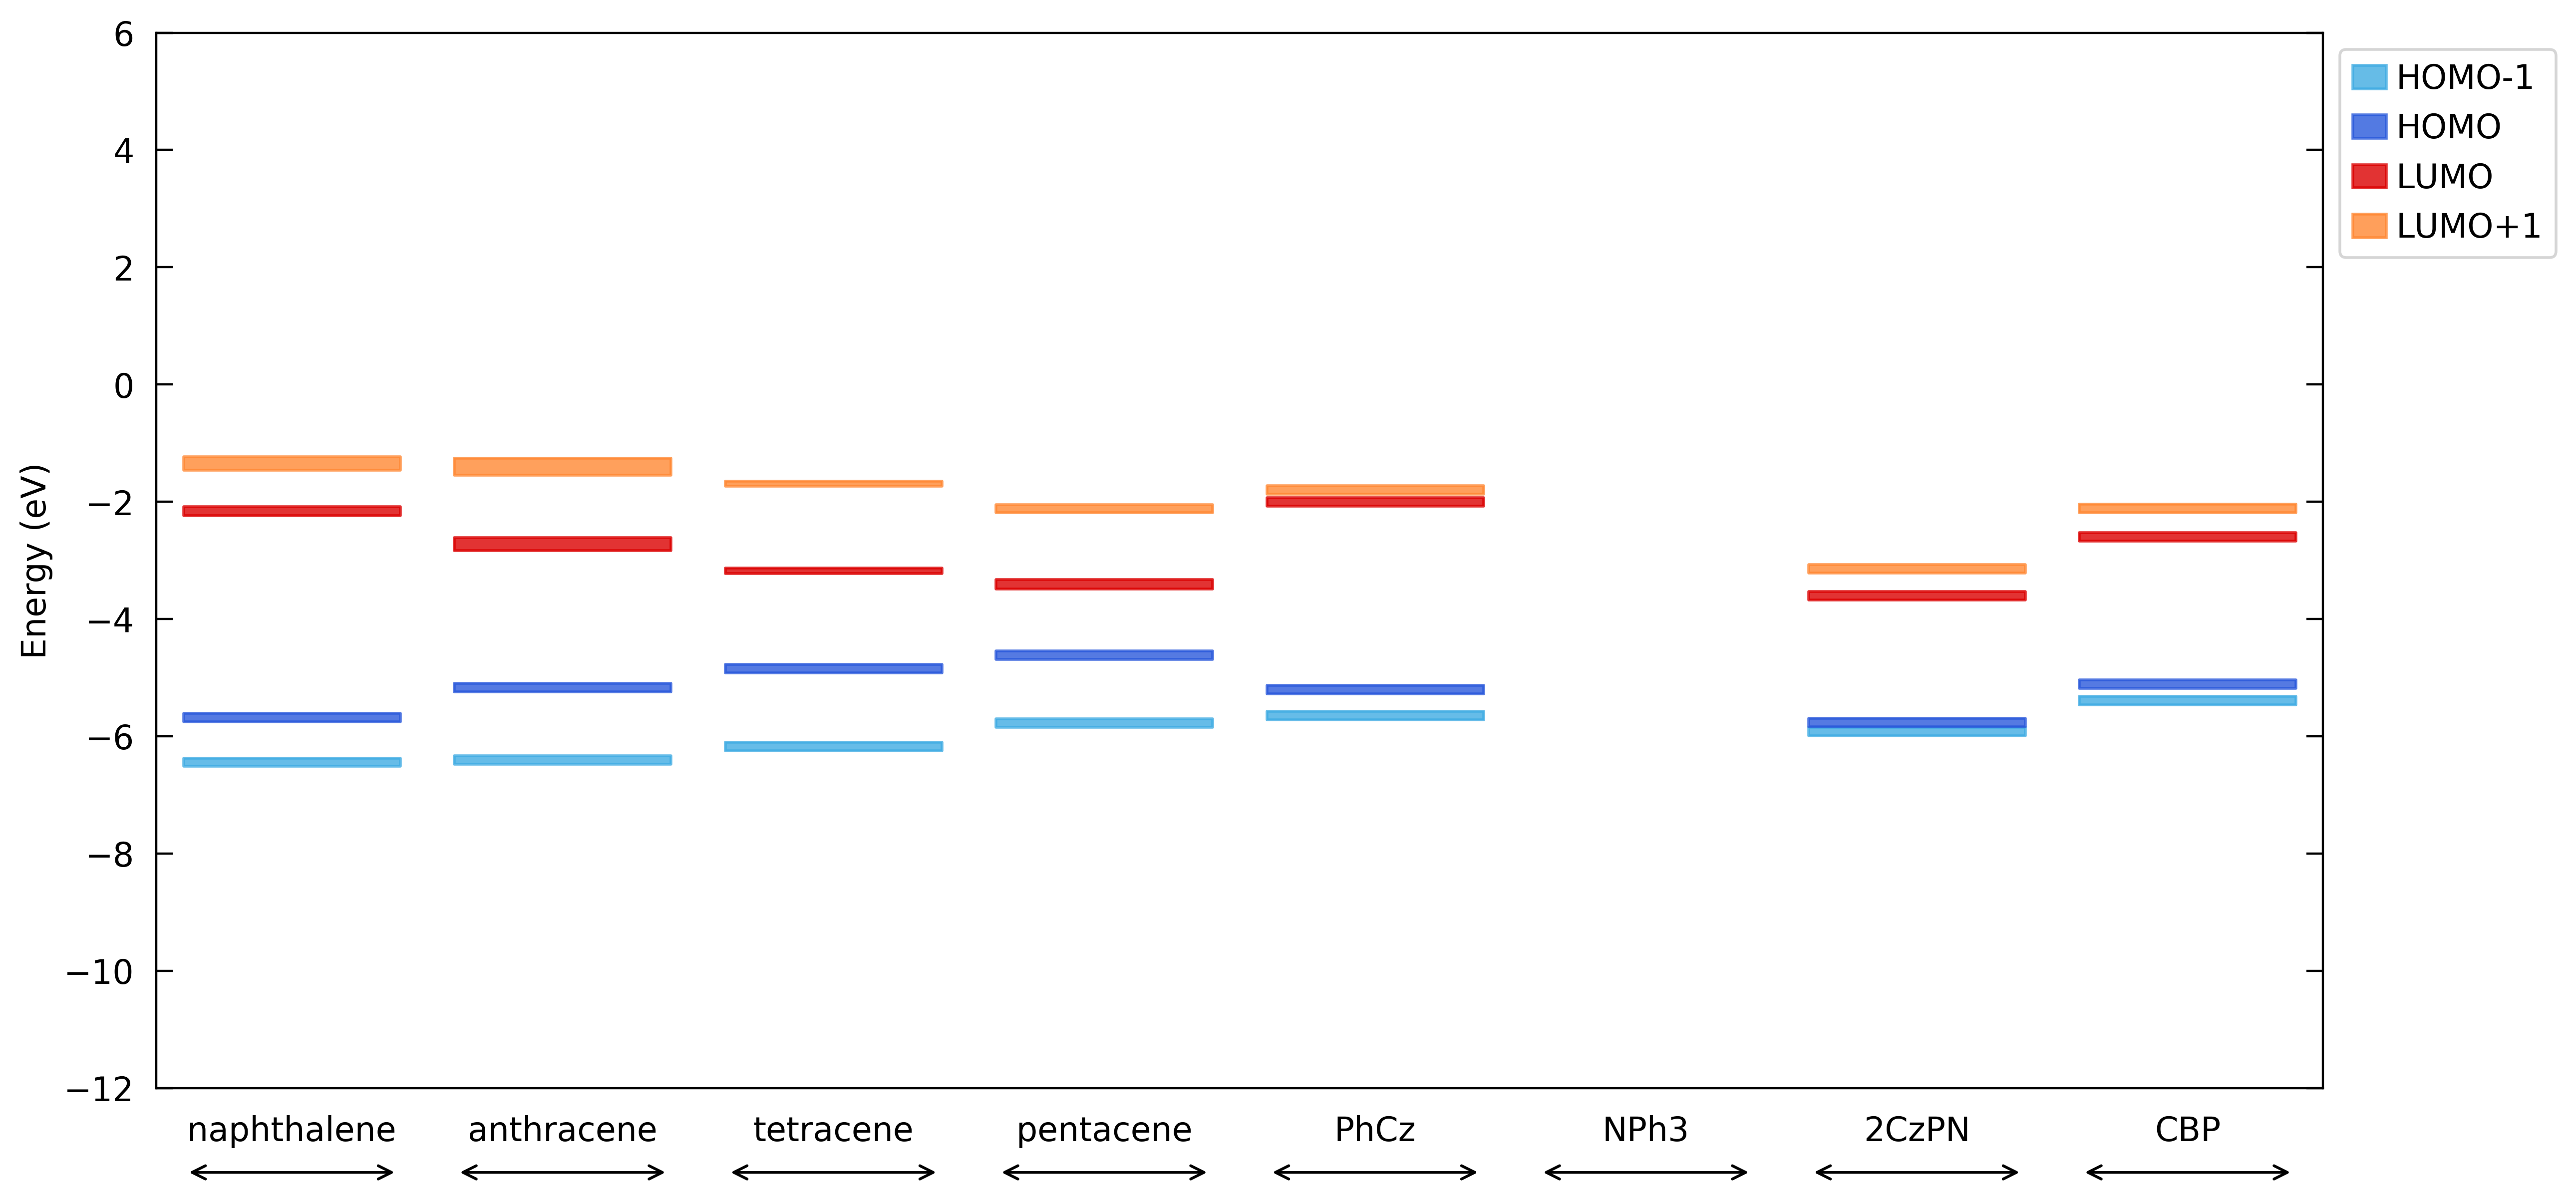

PBE


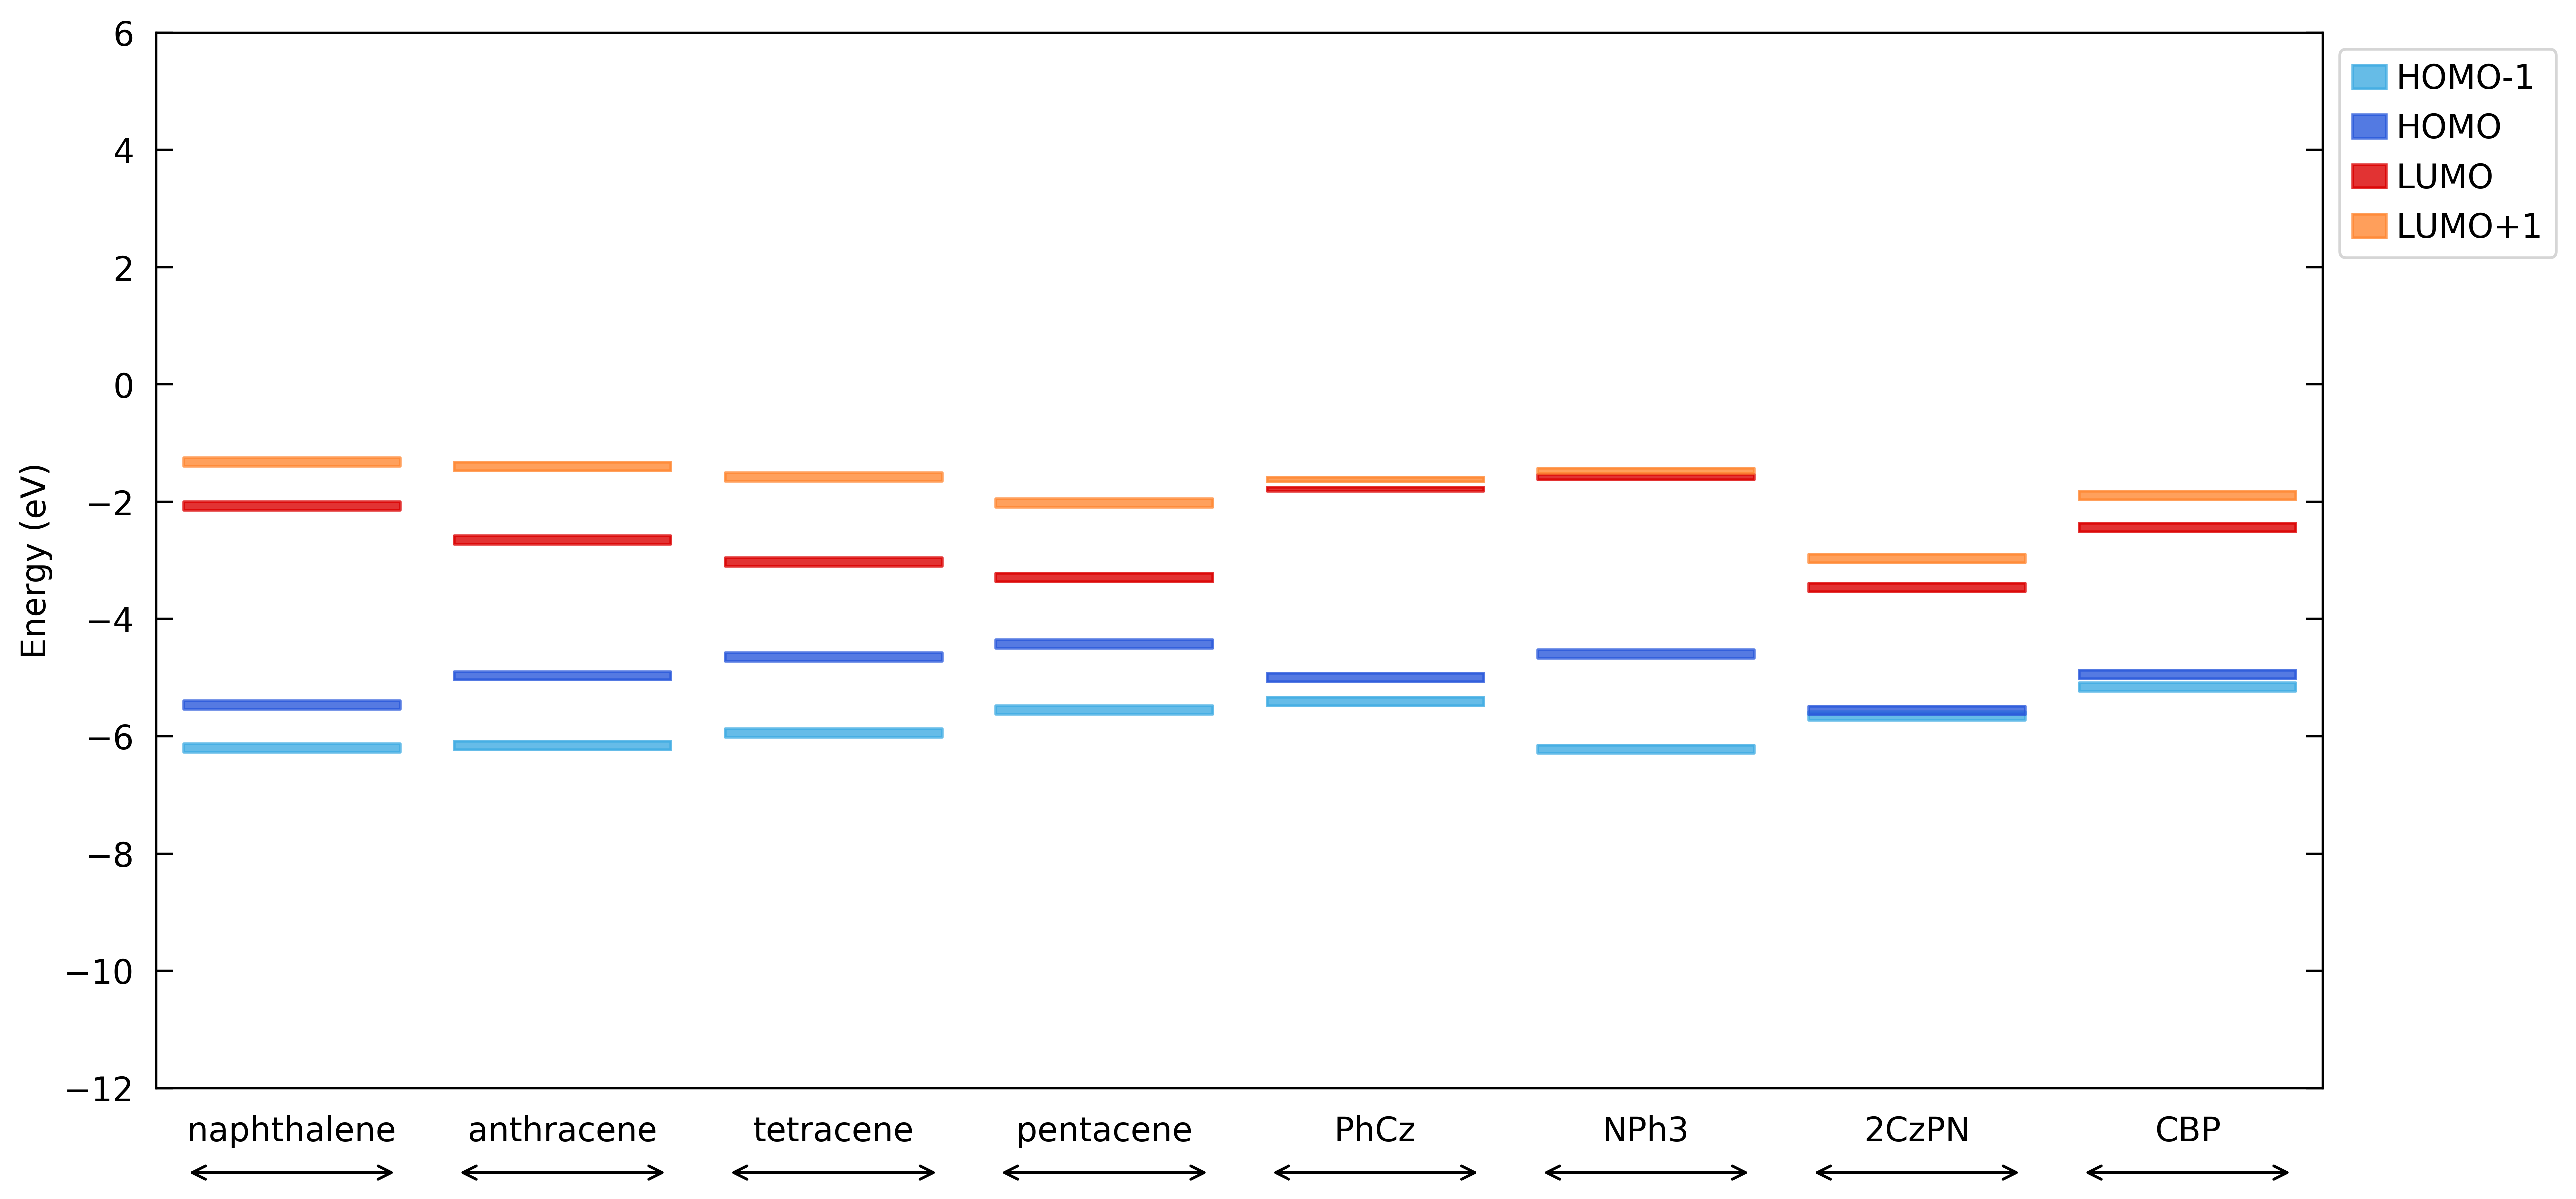

B3LYP


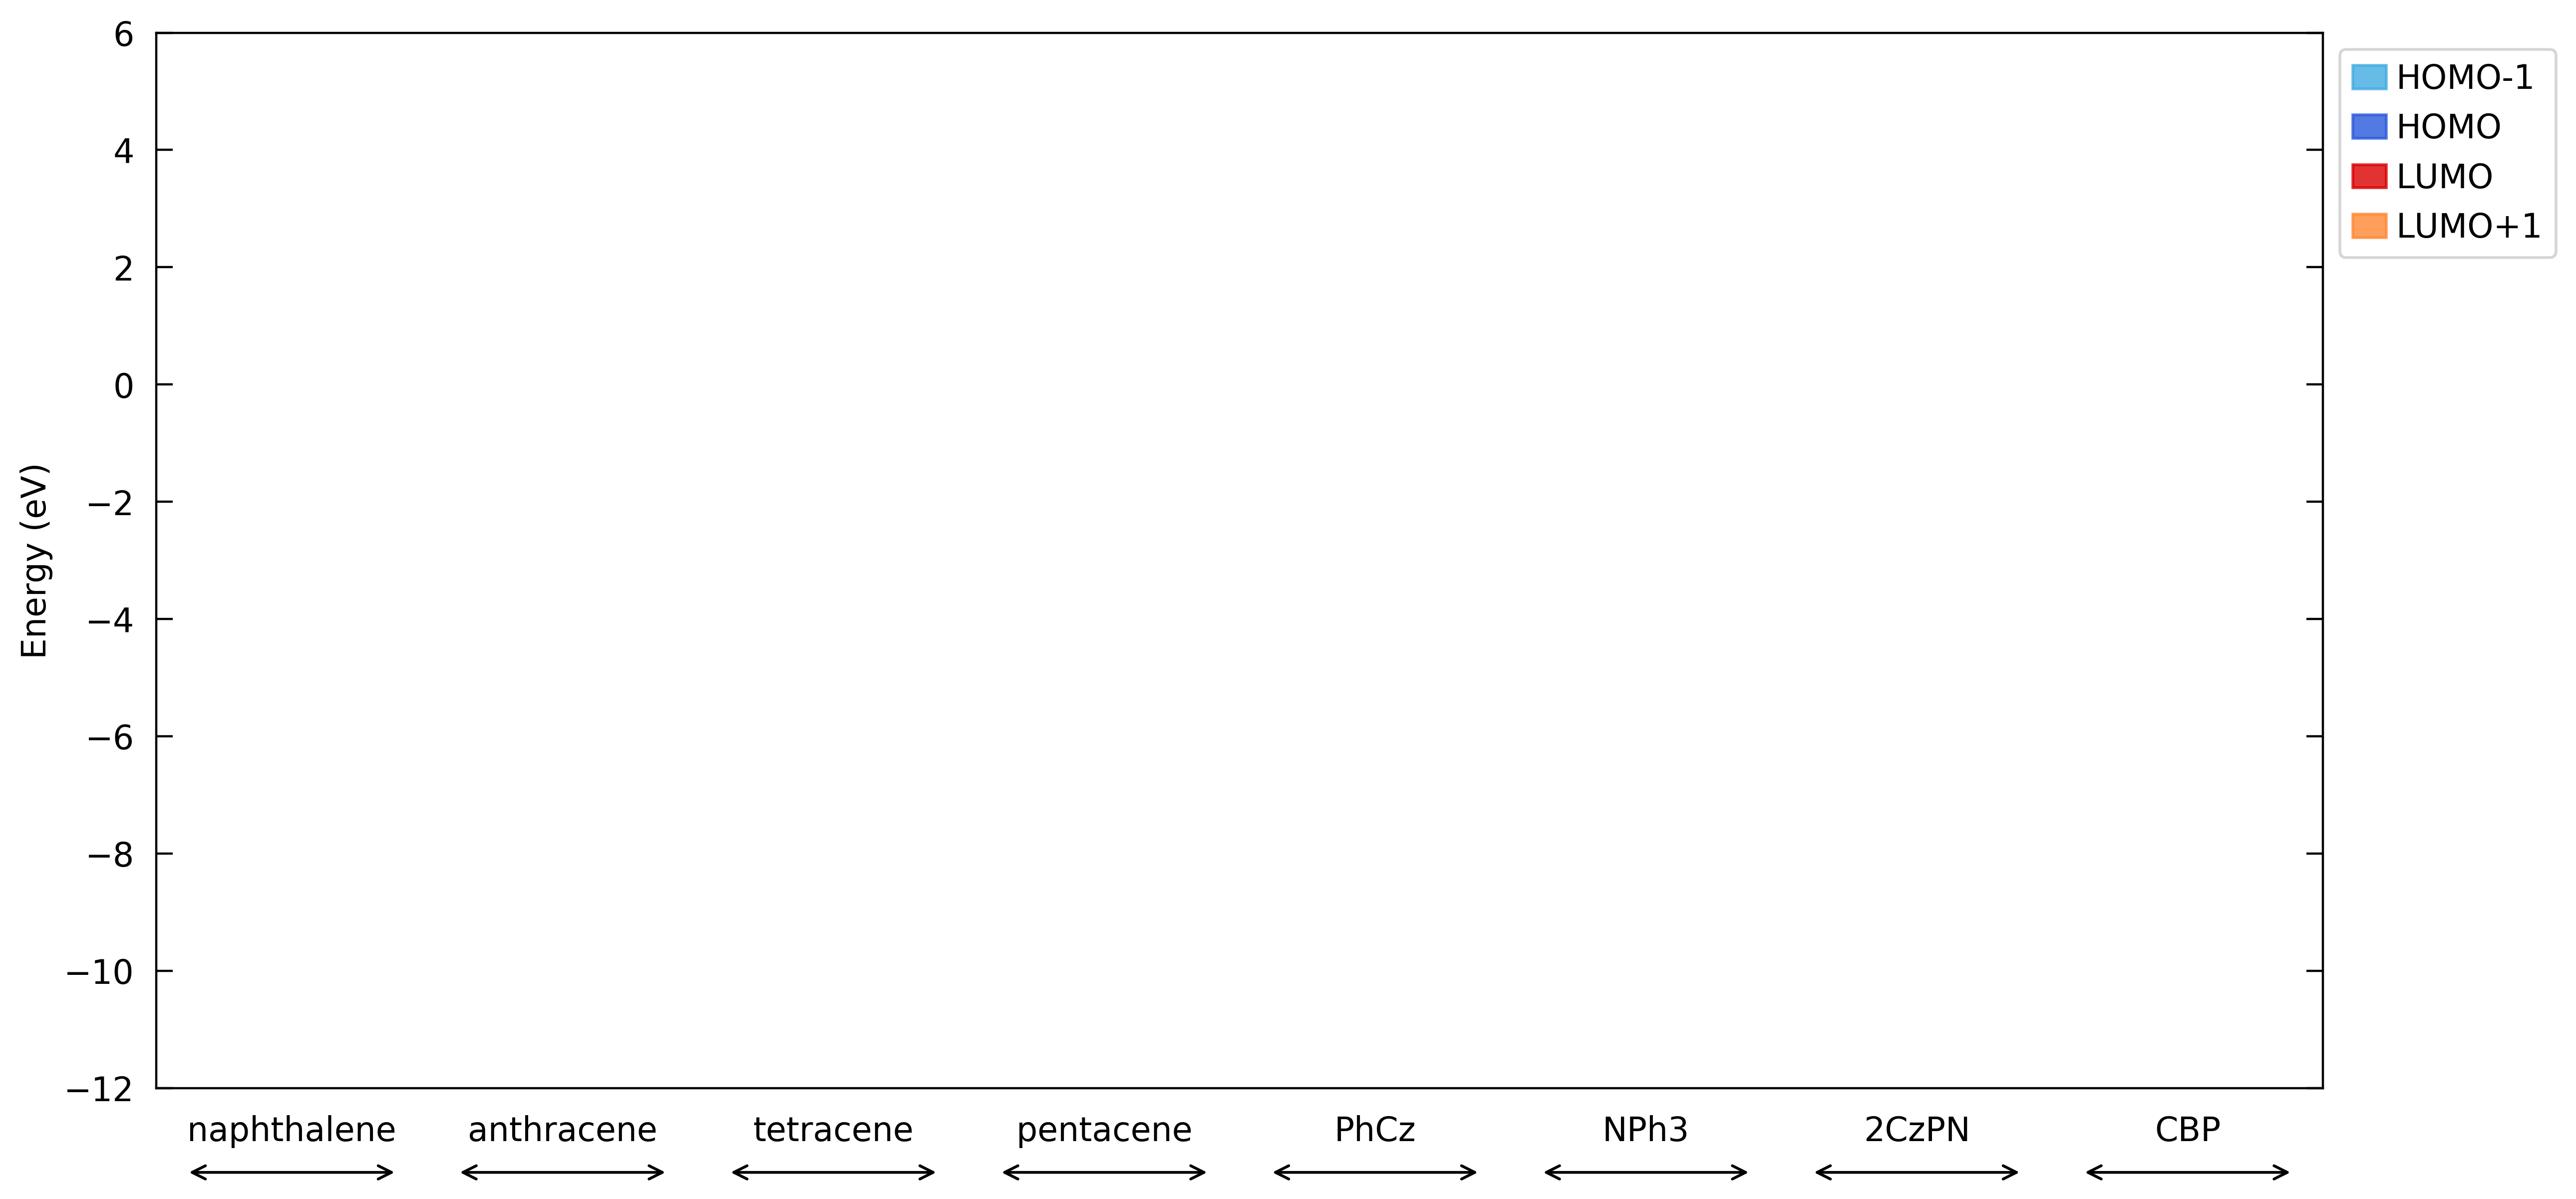

HF


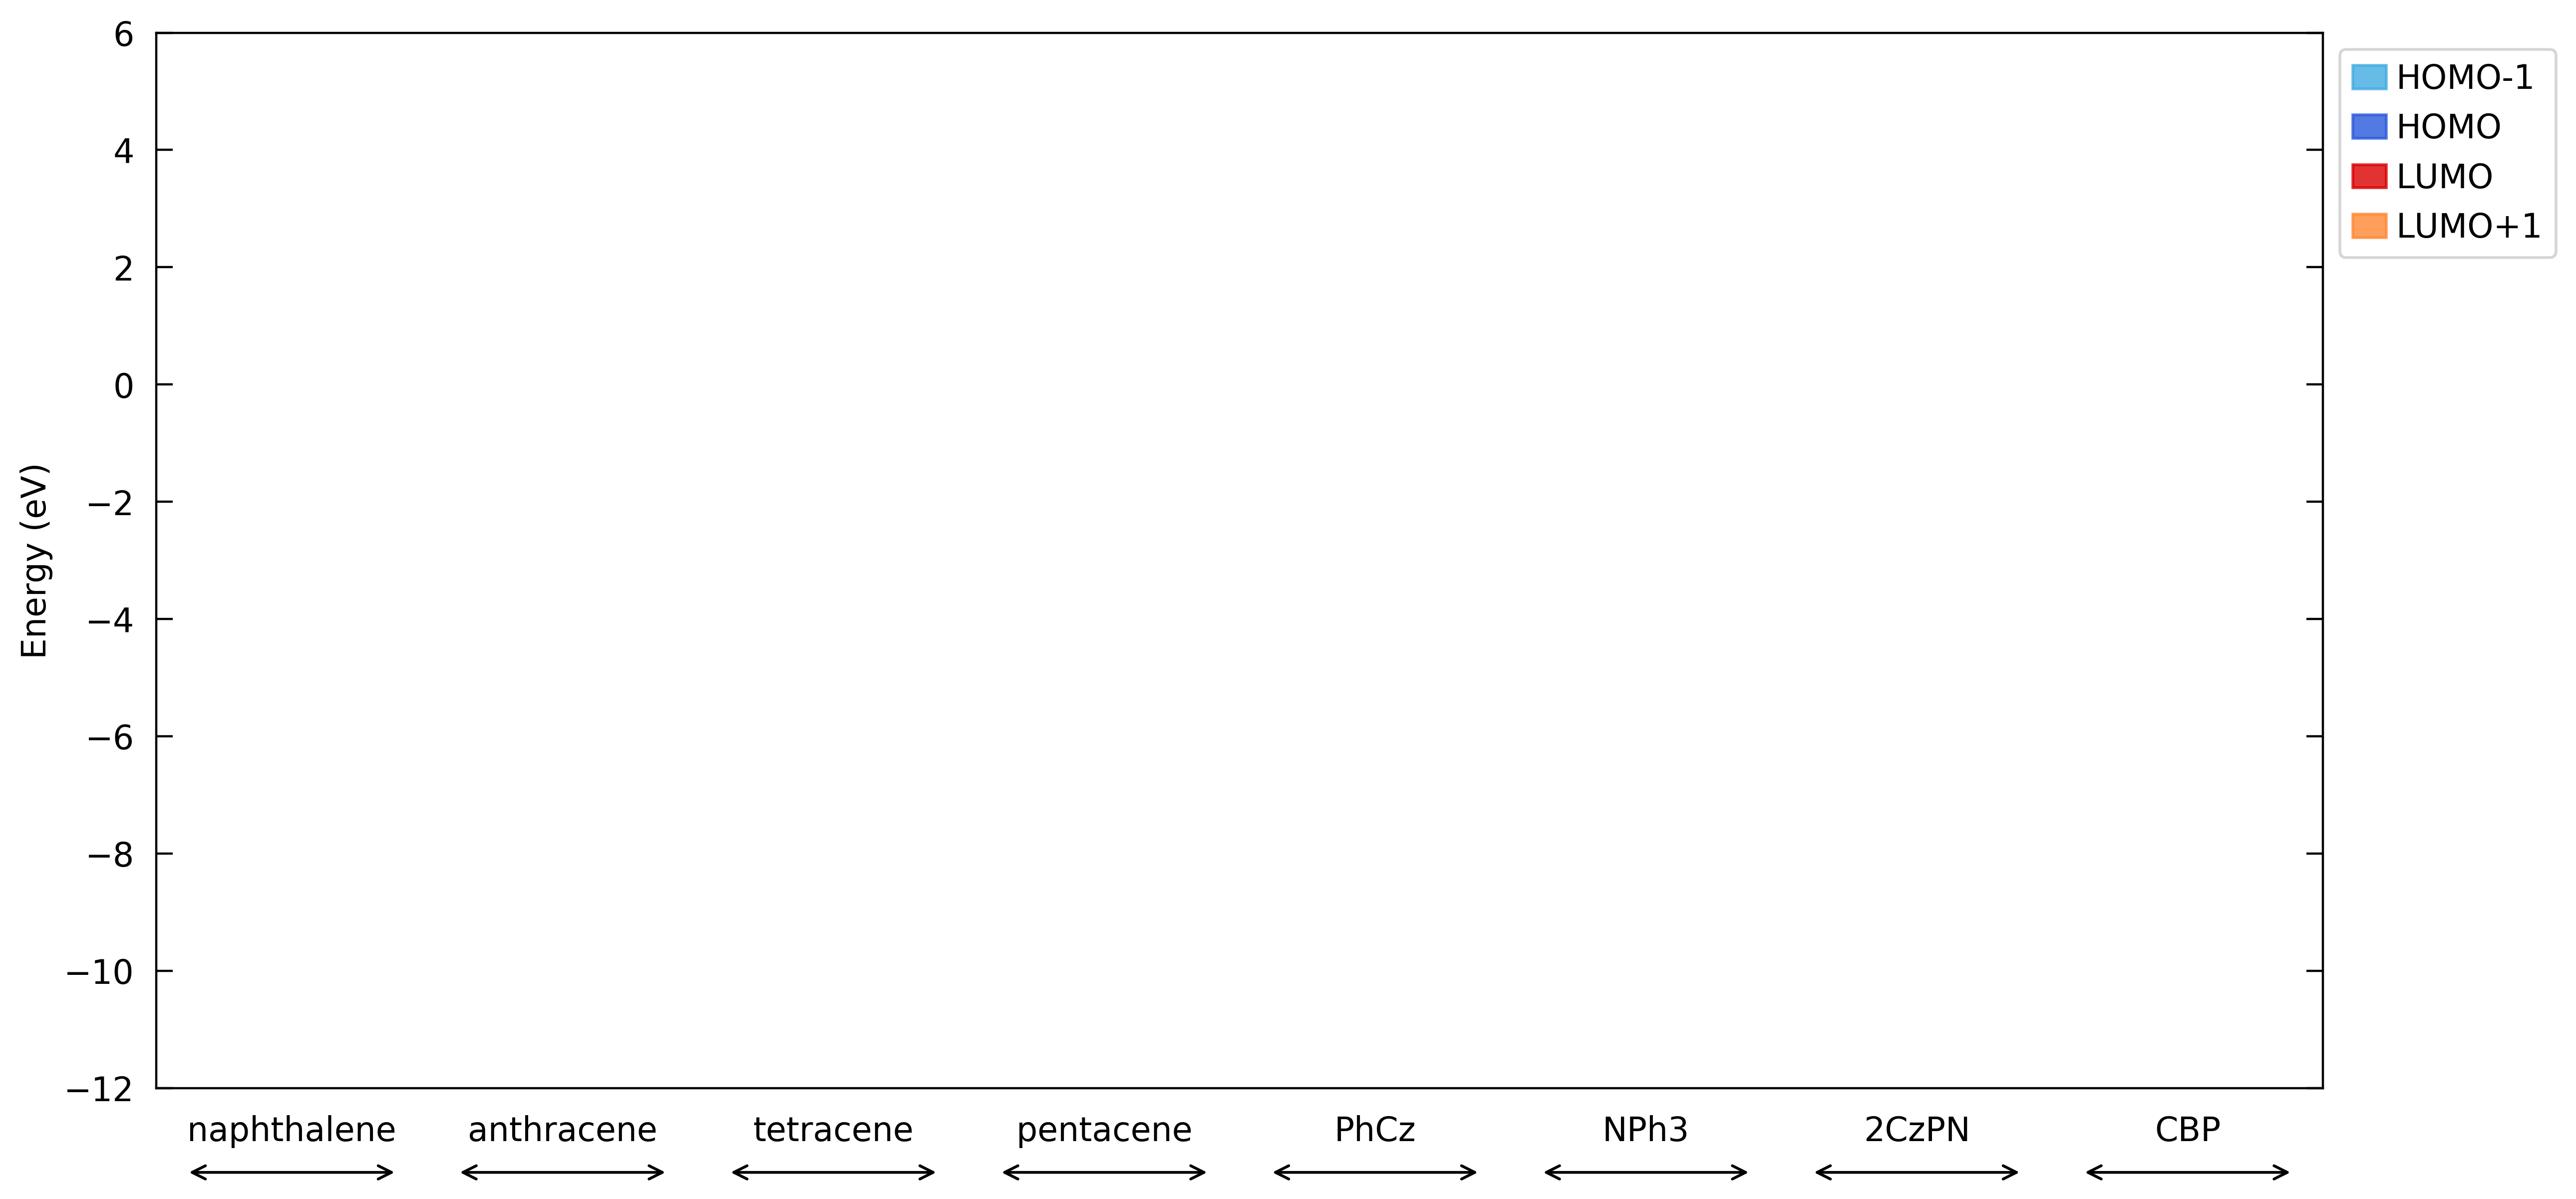

In [10]:
def plot_homo_lumo_condense(molecules, xc, HL_order, data_H_L, emin=0, emax=1, font_size=12, width=3.5, height=3.5):
    import matplotlib.pyplot as plt   

    #ncol = len(molecules)
    #nrow = int(np.ceil(float(len(molecules)) / ncol))
    plt.rcParams.update({'font.size': font_size})
    fig, ax = plt.subplots(1, 1, figsize=(width, height))
    #fig.subplots_adjust(hspace=0.05)
    #fig.subplots_adjust(wspace=0.2)
    
    erange = emax - emin
    det = 0.004 * erange
    
    xmin = 0
    x = 0
    dx = 0.5
    ddx = 0.05

    for m,molecule in enumerate(molecules):
        
        yl = - 0.08
        ax.annotate('', xy=(x + ddx, yl), xycoords=("data", "axes fraction"), xytext=(x + dx - ddx, yl),
                            arrowprops=dict(arrowstyle="<->", color='k'))

        ax.text(x + 0.5 * dx, emin - 0.05 * erange, molecule, horizontalalignment='center')
             
        for ih,HL in enumerate(HL_order):
                
            e = data_H_L[molecule][xc][HL]
              
            if m == 0:
                label = HL
            else:
                label = None
             
            if HL == 'HOMO-1':
                color = plotting_wrappers.colorsb[1]
            elif HL == 'HOMO':
                color = plotting_wrappers.colorsb[2]
            elif HL == 'LUMO':
                color = plotting_wrappers.colorso[2]
            elif HL == 'LUMO+1':
                color = plotting_wrappers.colorso[1]
        
            if isinstance(e, list):
                # if we have a list of values, we want to show the spread
                e0 = min(e)
                e1 = max(e)
                # in case these are identical, give the line a minimum thickness for visibility
                if e1 - e0 < det:
                    pad = det - 0.5 * (e1 - e0)
                    e0 -= pad
                    e1 += pad
                    
                ax.fill_betweenx([e0, e1], [x + ddx, x + ddx], [x + dx - ddx, x + dx - ddx],
                                 alpha=0.8, color=color, label=label) #, hatch='x')
            else:
                ax.fill_betweenx([e - 0.5 * det, e + 0.5 * det],
                                 [x + ddx, x + ddx], [x + dx - ddx, x + dx - ddx],
                                 alpha=0.8, color=color, label=label) #, hatch='x')
                    
        x += dx

    plotting_wrappers.set_plot_parameters(ax, xmin, x, emin, emax, 'NONE', 'Energy (eV)',
                    'NONE', 'DEFAULT', 'NONE', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'outside', ncol=1)
    plt.show()
    
    
    
for xc in xcs:
    print xc
    plot_homo_lumo_condense(molecules, xc, HL_order, data_H_L, emin=-12, emax=6, font_size=12, width=14, height=7.0)
    

In [9]:
# def plot_homo_lumo(molecules, xc, HL_order, data, emin=0, emax=1, font_size=12, width=3.5, height=3.5):
#     import matplotlib.pyplot as plt   

#     #ncol = len(molecules)
#     #nrow = int(np.ceil(float(len(molecules)) / ncol))
#     plt.rcParams.update({'font.size': font_size})
#     fig, ax = plt.subplots(1, 1, figsize=(width, height))
#     #fig.subplots_adjust(hspace=0.05)
#     #fig.subplots_adjust(wspace=0.2)
    
#     erange = emax - emin
#     det = 0.004 * erange
    
#     xmin = 0
#     x = 0
#     dx = 0.5
#     ddx = 0.05

#     for m,molecule in enumerate(molecules):
        
#         yl = - 0.08
#         ax.annotate('', xy=(x + ddx, yl), xycoords=("data", "axes fraction"), xytext=(x + dx - ddx, yl),
#                             arrowprops=dict(arrowstyle="<->", color='k'))

#         ax.text(x + 0.5 * dx, emin - 0.05 * erange, molecule, horizontalalignment='center')
             
#         for ih,HL in enumerate(HL_order):
                
#             e = data[molecule][code][xc][bas][HL]
              
#             if m == 0:
#                 label = HL
#             else:
#                 label = None
             
#             if HL == 'HOMO-1':
#                 color = plotting_wrappers.colorsb[1]
#             elif HL == 'HOMO':
#                 color = plotting_wrappers.colorsb[2]
#             elif HL == 'LUMO':
#                 color = plotting_wrappers.colorso[2]
#             elif HL == 'LUMO+1':
#                 color = plotting_wrappers.colorso[1]
        
#             if isinstance(e, list):
#                 # if we have a list of values, we want to show the spread
#                 e0 = min(e)
#                 e1 = max(e)
#                 # in case these are identical, give the line a minimum thickness for visibility
#                 if e1 - e0 < det:
#                     pad = det - 0.5 * (e1 - e0)
#                     e0 -= pad
#                     e1 += pad
                    
#                 ax.fill_betweenx([e0, e1], [x + ddx, x + ddx], [x + dx - ddx, x + dx - ddx],
#                                  alpha=0.8, color=color, label=label) #, hatch='x')
#             else:
#                 ax.fill_betweenx([e - 0.5 * det, e + 0.5 * det],
#                                  [x + ddx, x + ddx], [x + dx - ddx, x + dx - ddx],
#                                  alpha=0.8, color=color, label=label) #, hatch='x')
                    
#         x += dx

#     plotting_wrappers.set_plot_parameters(ax, xmin, x, emin, emax, 'NONE', 'Energy (eV)',
#                     'NONE', 'DEFAULT', 'NONE', 'DEFAULT', 'DEFAULT', 'DEFAULT', 1.0, 'outside', ncol=1)
#     plt.show()
    
# for code in codes:    
#     for bas in basis:
#         if bas in code_to_bas[code]:
#             for xc in bas_to_xc[bas]:
#                 print code, xc, bas
#                 plot_homo_lumo(molecules, xc, HL_order, data, emin=-10, emax=2, font_size=12, width=14, height=7.0)
    